# FEM Modelling for Three-Phase STEDIN Transformer

### Transient + Voltage fed Analysis

General FEM equation, 
\begin{equation}
    Au + B \frac{\partial u}{\partial t} = f
\end{equation}

Circuit equation,
\begin{equation}
    V = G'\frac{\partial u}{\partial t} + R_{ext}I + L_{ext} \frac{\partial I}{\partial t}
\end{equation}

Combining and writing in time-stepping format,
\begin{equation}
    \begin{bmatrix}
        \frac{B}{\Delta t} + A & -f \\
        \frac{G^T}{\Delta t} & R_{ext} + \frac{L_{ext}}{\Delta t}
    \end{bmatrix} \begin{bmatrix}
        u \\
        I
    \end{bmatrix}^{t+\Delta t} = \begin{bmatrix}
        \frac{B}{\Delta t} & 0 \\
        \frac{G^T}{\Delta t} & \frac{L_{ext}}{\Delta t}
    \end{bmatrix} \begin{bmatrix}
        u \\
        I
    \end{bmatrix}^{t} + \begin{bmatrix}
        0 \\
        V^{t+\Delta t}
    \end{bmatrix}
\end{equation}

Simplifying,
\begin{equation}
    \begin{bmatrix}
        B + \Delta t A & - \Delta t f \\
        G^T & \Delta t R_{ext} + L_{ext}
    \end{bmatrix} \begin{bmatrix}
        u \\
        I
    \end{bmatrix}^{t+\Delta t} = \begin{bmatrix}
        B & 0 \\
        G^T & L_{ext}
    \end{bmatrix} \begin{bmatrix}
        u \\
        I
    \end{bmatrix}^{t} + \begin{bmatrix}
        0 \\
        \Delta t V^{t+\Delta t}
    \end{bmatrix}
\end{equation}

## Import Packages

In [1]:
using gmsh
using LinearAlgebra
using LaTeXStrings
using Plots
using CSV
using DataFrames
include("../../../../lib/Makie_Plots.jl");
using .Makie_Plots
include("../../../../lib/FEM_Transient_VoltageFed_Tri_1e.jl");
using .FEM_Transient_VoltageFed_Tri_1e
include("../../../../lib/Post_Process_Time.jl");
using .Post_Process_Time
include("../../../../lib/Mesh_Data_stedin.jl");
using .Mesh_Data_stedin
include("../../../../lib/Save_VTK.jl");
using .Save_VTK

## Julia code

In [2]:
gmsh.initialize()

## Read mesh from file
gmsh.open("../../../../Geometry/mesh/stedin_transformer.msh")

mesh_data = get_mesh_data_tri_1e(gmsh)

Ip = 17.54;   # Primary peak phase current
Is = 777.62;  # Secondary peak phase current
Vp = 15202.40;   # Primary peak phase voltage
Vs = 342.93;     # Secondary peak phase voltage
Np = 266;
Ns = 6;

omega = 2*pi*50;  # Frequency

# HV winding dimensions (all phases left/right are identical)
wwhv = 3e-2;
hwhv = 74e-2;
mwhv = 14.75e-2;
Awhv = wwhv * hwhv;

# LV winding dimensions (all phases left/right are identical)
wwlv = 2e-2;
hwlv = 74e-2;
mwlv = 11.25e-2;
Awlv = wwlv * hwlv;

# Calculate turn density in the windings
Tp = Np / Awhv;
Ts = Ns / Awlv;

# Specify time start, end and step
init_time = 0
n_cycles = 10
final_time = n_cycles*(2*pi/omega)
dt = (final_time-init_time) / (100*n_cycles)
time_steps = Vector(init_time:dt:final_time)

# Source turn density T
# One term for each of the windings, with a positive and negative part
sourcefunction(group_id) = [Tp*(1*(group_id==3))  -Tp*(1*(group_id==4)) Tp*(1*(group_id==5))  -Tp*(1*(group_id==6)) Tp*(1*(group_id==7))  -Tp*(1*(group_id==8))   Ts*(1*(group_id==9))  -Ts*(1*(group_id==10)) Ts*(1*(group_id==11))  -Ts*(1*(group_id==12)) Ts*(1*(group_id==13))  -Ts*(1*(group_id==14))];
sourceperelement = map(sourcefunction, mesh_data.e_group);

# Source voltage V
# One term for each of the windings, with a positive and negative part
coil_voltage = [Vp*exp(1im*-2pi/3); Vp*exp(1im*-2pi/3); Vp; Vp; Vp*exp(1im*2pi/3); Vp*exp(1im*2pi/3); 0; 0; 0; 0; 0; 0];

# External resistance Rext
# One term for each of the windings, with a positive and negative part
ext_resistance = [90.655; 90.655; 90.655; 90.655; 90.655; 90.655; 1.2999e-3; 1.2999e-3; 1.2999e-3; 1.2999e-3; 1.2999e-3; 1.2999e-3];

# External resistance Rext
# One term for each of the windings, with a positive and negative part
ext_inductance = 1e-4.*[1; 1; 1; 1; 1; 1; 1; 1; 1; 1; 1; 1];

# Relative permeability model
mu0 = 4e-7 * pi;
mur = 2.5e4;       # Relative permeability of the core
reluctivityfunction(group_id) = (1 / mu0) + (1/(mu0*mur) - 1/mu0) * (group_id == 2)
reluctivityperelement = map(reluctivityfunction, mesh_data.e_group);

# Conductivity
conductivityfunction(group_id) = 0;
conductivityperelement = map(conductivityfunction, mesh_data.e_group);

# Handle the boundary conditions
bnd_node_ids, _ = gmsh.model.mesh.getNodesForPhysicalGroup(1, 1);

# Calculate the vector potential
@time u = fem(mesh_data, sourceperelement, reluctivityperelement, conductivityperelement, omega, bnd_node_ids, coil_voltage, ext_resistance, ext_inductance, time_steps);

# Post-process for magnetic field and current density
@time Bx, By, B, Hx, Hy, H, mag_energy = post_process(mesh_data, u, reluctivityperelement, time_steps);

gmsh.finalize()

Info    : Reading '../../../../Geometry/mesh/stedin_transformer.msh'...
Info    : 168 entities
Info    : 10385 nodes
Info    : 20768 elements
Info    : Done reading '../../../../Geometry/mesh/stedin_transformer.msh'
 88.322759 seconds (16.71 M allocations: 33.617 GiB, 1.34% gc time, 5.53% compilation time)
 61.609648 seconds (451.77 M allocations: 23.521 GiB, 9.76% gc time, 1.51% compilation time)


## Plots

In [3]:
selected_node = 4276
selected_element = 7051
u_wave = [u_curr[selected_node] for u_curr in u];
V1_wave = complex(zeros(length(time_steps),1))
for k = 1:length(time_steps)
    V1_wave[k] = coil_voltage[1].*exp(1im*omega*time_steps[k])
end
I1_wave = [u_curr[end-2] for u_curr in u];
Bx_wave = [Bx_curr[selected_element] for Bx_curr in Bx];
By_wave = [By_curr[selected_element] for By_curr in By];
B_wave = [B_curr[selected_element] for B_curr in B];
Hx_wave = [Hx_curr[selected_element] for Hx_curr in Hx];
Hy_wave = [Hy_curr[selected_element] for Hy_curr in Hy];
H_wave = [H_curr[selected_element] for H_curr in H];
mag_energy_wave = [mag_energy_curr[selected_element] for mag_energy_curr in mag_energy];

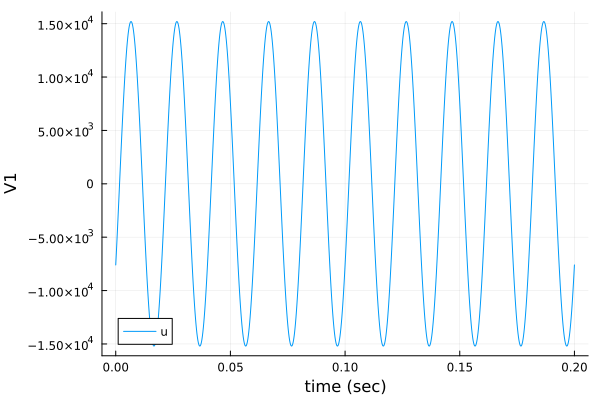

In [4]:
plot(time_steps, real(V1_wave), label = "u")
xlabel!("time (sec)")
ylabel!("V1")

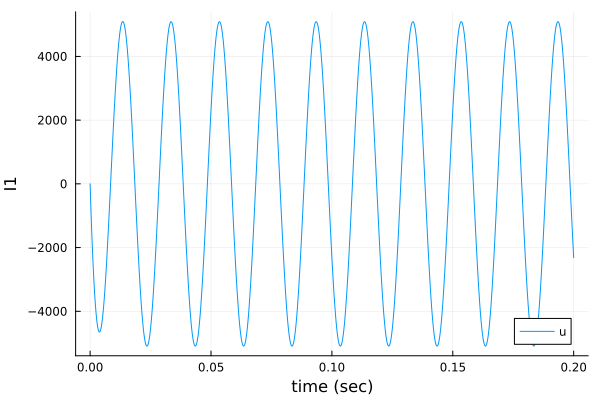

In [5]:
plot(time_steps, real(I1_wave), label = "u")
xlabel!("time (sec)")
ylabel!("I1")

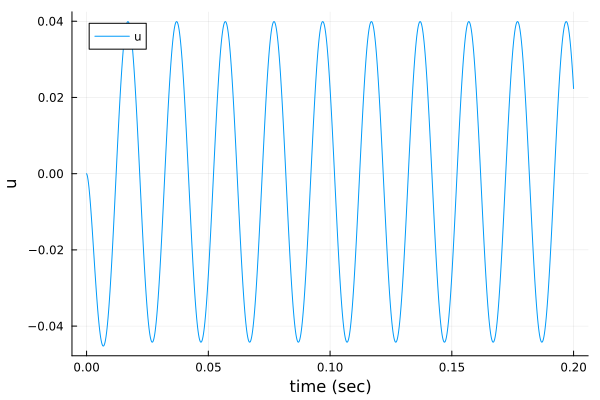

In [6]:
plot(time_steps, real(u_wave), label = "u")
xlabel!("time (sec)")
ylabel!("u")

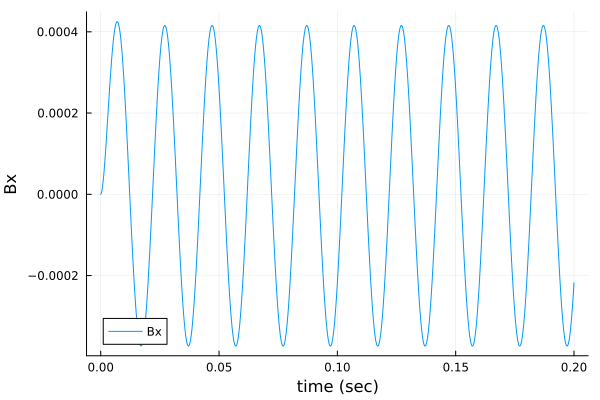

In [7]:
plot(time_steps, real(Bx_wave), label = "Bx")
xlabel!("time (sec)")
ylabel!("Bx")

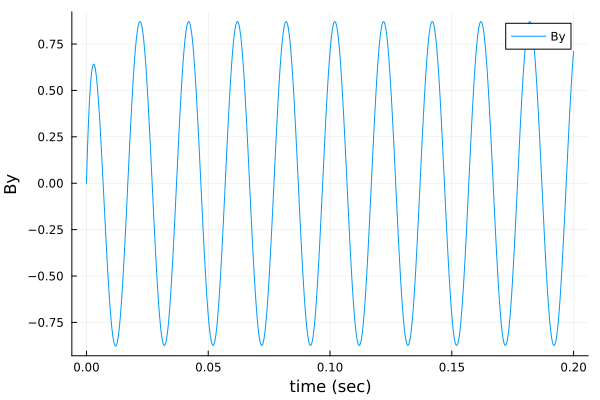

In [8]:
plot(time_steps, real(By_wave), label = "By")
xlabel!("time (sec)")
ylabel!("By")

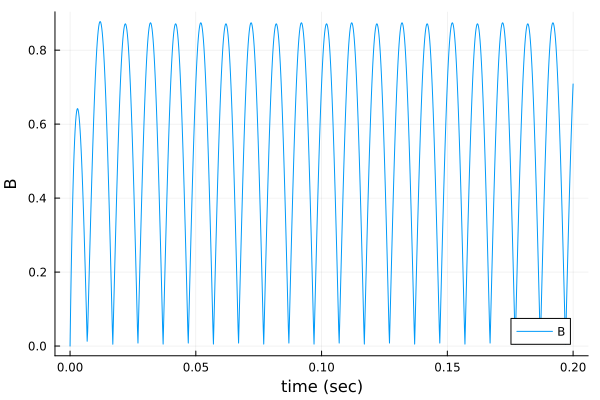

In [9]:
plot(time_steps, real(B_wave), label = "B")
xlabel!("time (sec)")
ylabel!("B")

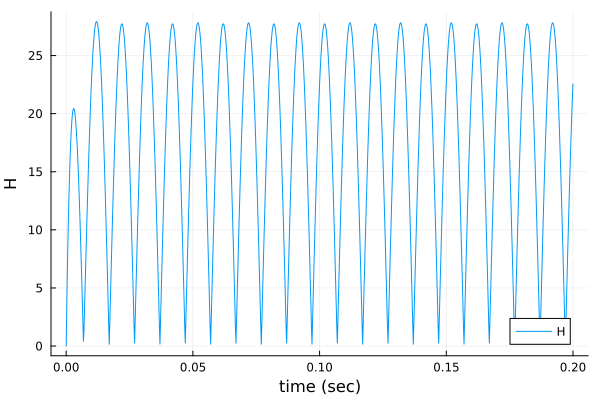

In [10]:
plot(time_steps, real(H_wave), label = "H")
xlabel!("time (sec)")
ylabel!("H")

In [13]:
Bx_mat = DataFrame(real(hcat(Bx...)), :auto)
CSV.write("../csv/stedin_transformer_Bx_voltagefed.csv", Bx_mat)
By_mat = DataFrame(real(hcat(By...)), :auto)
CSV.write("../csv/stedin_transformer_By_voltagefed.csv", By_mat)
B_mat = DataFrame(real(hcat(B...)), :auto)
CSV.write("../csv/stedin_transformer_B_voltagefed.csv", B_mat)
Hx_mat = DataFrame(real(hcat(Hx...)), :auto)
CSV.write("../csv/stedin_transformer_Hx_voltagefed.csv", Hx_mat)
Hy_mat = DataFrame(real(hcat(Hy...)), :auto)
CSV.write("../csv/stedin_transformer_Hy_voltagefed.csv", Hy_mat)
H_mat = DataFrame(real(hcat(H...)), :auto)
CSV.write("../csv/stedin_transformer_H_voltagefed.csv", H_mat)
mag_energy_mat = DataFrame(real(hcat(mag_energy...)), :auto)
CSV.write("../csv/stedin_transformer_mag_energy_voltagefed.csv", mag_energy_mat)

"../csv/stedin_transformer_mag_energy_voltagefed.csv"

In [12]:
display(maximum(real(B_wave)))

0.8773027724731284